In [23]:
import pandapower as pp
import pandapower.networks as pn
import pandas as pd
import numpy as np
import os
import sys
import networkx as nx

try:
    from powergrid_synth.generator import PowerGridGenerator
    from powergrid_synth.exporter import GridExporter
    from powergrid_synth.bus_type_allocator import BusTypeAllocator
    from powergrid_synth.comparison import GraphComparator
    from powergrid_synth.data_format_converter import pandapower_to_nx
except ImportError:
    print("Could not import powergrid_synth. Please ensure you are running from the correct directory.")

In [24]:
def extract_topology_params_from_graph(G):
    """
    Extracts degrees, diameters, and transformer stats from a NetworkX graph.
    This is required to configure the synthesizer to mimic the reference grid.
    """
    print("Extracting topology parameters...")
    
    levels = sorted(list(set(nx.get_node_attributes(G, 'voltage_level').values())))
    
    degrees_by_level = []
    diameters_by_level = []
    transformer_degrees = {}
    
    # Per Level Stats
    for lvl in levels:
        nodes = [n for n, d in G.nodes(data=True) if d['voltage_level'] == lvl]
        subG = G.subgraph(nodes)
        
        degs = [d for n, d in subG.degree()]
        degrees_by_level.append(degs)
        
        if len(nodes) > 0:
            if nx.is_connected(subG):
                diam = nx.diameter(subG)
            else:
                largest_cc = max(nx.connected_components(subG), key=len)
                diam = nx.diameter(subG.subgraph(largest_cc))
        else:
            diam = 0
        diameters_by_level.append(diam)
        
    # Transformer Stats
    for i in range(len(levels)):
        for j in range(i + 1, len(levels)):
            nodes_i = [n for n, d in G.nodes(data=True) if d['voltage_level'] == i]
            nodes_j = [n for n, d in G.nodes(data=True) if d['voltage_level'] == j]
            
            if not nodes_i or not nodes_j: continue
            
            deg_i_to_j = []
            for n in nodes_i:
                count = sum(1 for neighbor in G.neighbors(n) if neighbor in nodes_j)
                deg_i_to_j.append(count)
                
            deg_j_to_i = []
            for n in nodes_j:
                count = sum(1 for neighbor in G.neighbors(n) if neighbor in nodes_i)
                deg_j_to_i.append(count)
                
            if sum(deg_i_to_j) > 0:
                transformer_degrees[(i, j)] = (deg_i_to_j, deg_j_to_i)

    return {
        'degrees_by_level': degrees_by_level,
        'diameters_by_level': diameters_by_level,
        'transformer_degrees': transformer_degrees
    }


In [25]:
print("============================================================")
print("         IEEE BENCHMARK: SYNTHETIC RECONSTRUCTION        ")
print("============================================================")

# 1. Load Real IEEE Grid and Convert
print("\n[1] Loading Reference Grid (IEEE)...")
net_real = pn.case118()
graph_real = pandapower_to_nx(net_real)
print(f"    Loaded {graph_real.number_of_nodes()} nodes and {graph_real.number_of_edges()} edges.")

# 2. Extract Topology Characteristics from Graph
print("\n[2] Analyzing Reference Topology...")
params = extract_topology_params_from_graph(graph_real)
print(params)

# 3. Generate Synthetic Grid
print("\n[3] Generating Synthetic Clone...")
gen = PowerGridGenerator(seed=140)
synthetic_graph = gen.generate_grid(
    degrees_by_level=params['degrees_by_level'],
    diameters_by_level=params['diameters_by_level'],
    transformer_degrees=params['transformer_degrees'],
    keep_lcc=True
)

# 4. Allocate Bus Types
print("\n[4] Allocating Bus Types via AIS...")
allocator = BusTypeAllocator(synthetic_graph)
# The allocator uses the graph size to determine target ratios dynamically
bus_types = allocator.allocate(max_iter=50)
nx.set_node_attributes(synthetic_graph, bus_types, name="bus_type")

# 5. Compare using the Library Module
print("\n[5] Running Comparative Analysis...")
comparator = GraphComparator(
    synth_graph=synthetic_graph, 
    ref_graph=graph_real, 
    synth_label="Synthetic", 
    ref_label="IEEE (Real)"
)

# Text-based reports
comparator.print_metric_comparison(title="GLOBAL TOPOLOGY COMPARISON")
comparator.print_level_metrics()

         IEEE BENCHMARK: SYNTHETIC RECONSTRUCTION        

[1] Loading Reference Grid (IEEE)...
    Loaded 118 nodes and 179 edges.

[2] Analyzing Reference Topology...
Extracting topology parameters...
{'degrees_by_level': [[2, 2, 2, 2, 1, 0, 0, 1, 3, 1, 2], [0, 0], [2, 2, 3, 2, 4, 2, 2, 4, 7, 2, 2, 5, 2, 5, 2, 4, 2, 2, 2, 4, 3, 2, 4, 2, 2, 3, 5, 2, 4, 2, 2, 5, 2, 4, 2, 3, 2, 2, 3, 3, 3, 2, 9, 2, 3, 2, 2, 5, 3, 5, 2, 2, 5, 3, 3, 4, 3, 2, 5, 5, 3, 2, 1, 2, 5, 2, 6, 2, 2, 6, 3, 3, 2, 5, 1, 2, 4, 2, 2, 6, 2, 5, 2, 5, 2, 2, 2, 8, 2, 2, 4, 3, 5, 3, 2, 2, 2, 4, 1, 1, 2, 2, 2, 1, 2]], 'diameters_by_level': [7, 0, 17], 'transformer_degrees': {(0, 1): ([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], [3, 0]), (0, 2): ([1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

>>> Running Global Comparison

GLOBAL GRAPH COMPARISON
            Metric Synthetic IEEE (Real)
             Nodes       118         118
             Edges       167         179
           Density  0.024192    0.025931
        Connected?       Yes         Yes
    Diameter (LCC)        15          14
Avg Path Len (LCC)    6.3031      6.3087
    Avg Clustering    0.1285      0.1651
      Transitivity    0.1055      0.1356



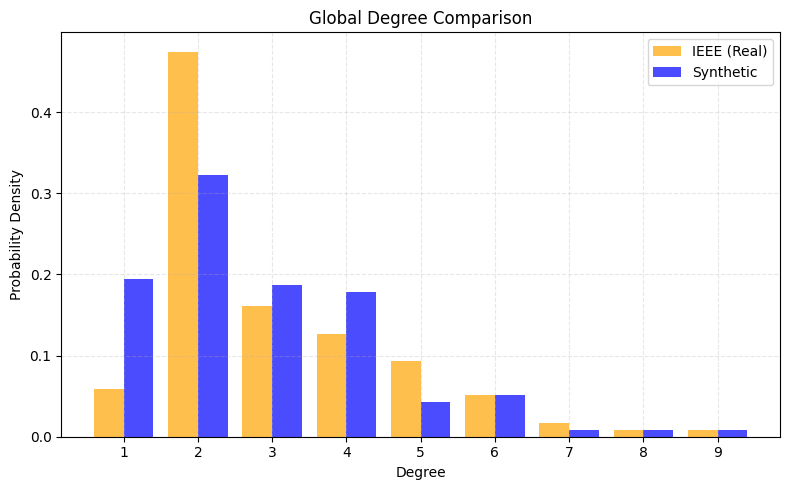

>>> Running Per-Level Metric Comparison

LEVEL 0 COMPARISON
            Metric Synthetic IEEE (Real)
             Nodes        14          11
             Edges        11           8
           Density  0.120879    0.145455
        Connected?        No          No
    Diameter (LCC)         8           7
Avg Path Len (LCC)    3.5303      3.0000
    Avg Clustering    0.0000      0.0000
      Transitivity    0.0000      0.0000


LEVEL 1 COMPARISON
            Metric Synthetic IEEE (Real)
             Nodes         2           2
             Edges         0           0
           Density  0.000000    0.000000
        Connected?        No          No
    Diameter (LCC)         0           0
Avg Path Len (LCC)    0.0000      0.0000
    Avg Clustering    0.0000      0.0000
      Transitivity    0.0000      0.0000


LEVEL 2 COMPARISON
            Metric Synthetic IEEE (Real)
             Nodes       102         105
             Edges       143         158
           Density  0.027762    0.028

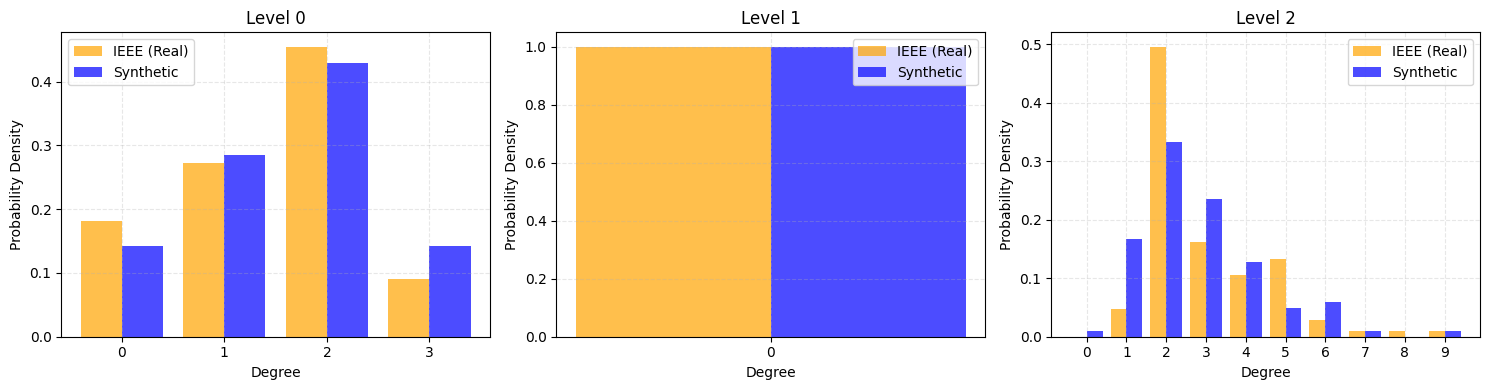

In [26]:
comparator.run_full_comparison(log_scale=False)